下面将使用预训练好的 VGG16 来训练猫和狗的分类网络。

In [6]:
from keras.applications import VGG16

In [7]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

In [9]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

有两种方式可以使用这个网络

- 在 `base_conv` 上运行用例，将结果保存，然后再使用这些结果来作为另一个包含 `Dense Layer` 的简单分类网络。
- 在 `base_conv` 上增加最后的 `Dense` 层分类，然后再在整个网络上跑用例。

In [10]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

In [13]:
train_dir = '/Users/bifnudozhao/Projects/ai-playground/datasets/train'
validation_dir = '/Users/bifnudozhao/Projects/ai-playground/datasets/validation'
test_dir = '/Users/bifnudozhao/Projects/ai-playground/datasets/test'

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary'
    )

    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [15]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

Found 2000 images belonging to 2 classes.
1/1 [==============================] - 1s 516ms/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 1s 515ms/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 1s 511ms/step


上面的代码执行预训练好的 VGG16，分别使用训练数据，验证数据与测试数据，得到一个中间结果。由于这个结果将要交给一个用于分类想全连接层，所以还需要 `reshape` 一下。

In [17]:
import tensorflow as tf
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=2e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 2097665 (8.00 MB)
Trainable params: 2097665 (8.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 1s 6ms/step - loss: 0.6037 - accuracy: 0.6680 - val_loss: 0.4444 - val_accuracy: 0.8410
Epoch 2/30
100/100 [==============================] - 1s 6ms/step - loss: 0.4254 - accuracy: 0.8095 - val_loss: 0.3609 - val_accuracy: 0.8690
Epoch 3/30
100/100 [==============================] - 0s 5ms/step - loss: 0.3578 - accuracy: 0.8525 - val_loss: 0.3267 - val_accuracy: 0.8900
Epoch 4/30
100/100 [==============================] - 0s 5ms/step - loss: 0.3172 - accuracy: 0.8745 - val_loss: 0.3007 - val_accuracy: 0.8820
Epoch 5/30
100/100 [==============================] - 0s 5ms/step - loss: 0.2858 - accuracy: 0.8815 - val_loss: 0.2882 - val_accuracy: 0.8860
Epoch 6/30
100/100 [==============================] - 1s 5ms/step - loss: 0.2661 - accuracy: 0.8910 - val_loss: 0.2748 - val_accuracy: 0.8880
Epoch 7/30
100/100 [==============================] - 0s 5ms/step - loss: 0.2589 - accuracy: 0.8950 - val_loss: 0.2667 - val_accuracy: 0.8970
Epoch 

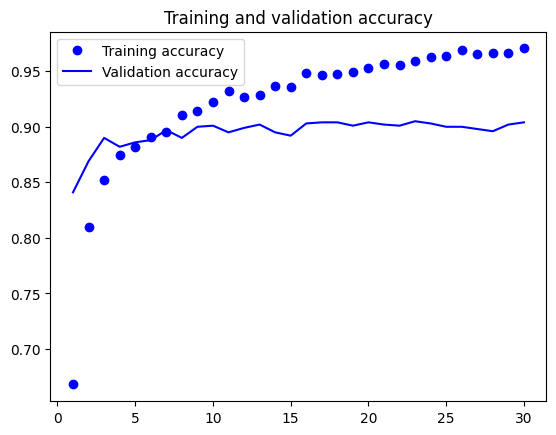

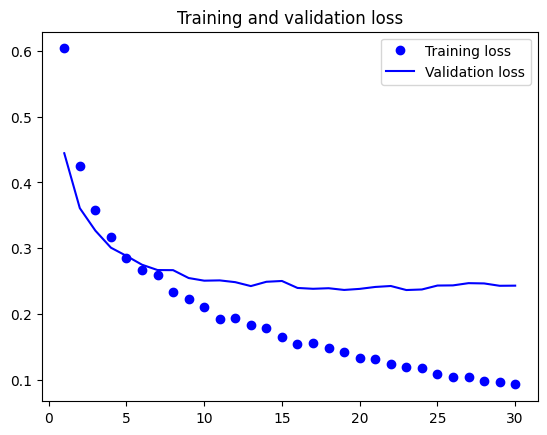

In [19]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

虽然从上面的图看来，验证数据集的正确率能达到 90%，但是从图中也能看出，几乎一开始就出现了过拟合，这是因为没有使用数据增强。下面将使用数据增强的方式来进行训练。